In [139]:
import pandas as pd
import numpy as np
import mygene
import seaborn as sns
from scipy.stats import randint
import matplotlib.pyplot as plt

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, r_regression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

In [140]:
## Load data into dataframes
df_2020_titer = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2020LD_plasma_ab_titer.tsv", sep='\t')
df_2020_gene = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2020LD_pbmc_gene_expression.tsv", sep='\t')
df_2020_specimen = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2020LD_specimen.tsv", sep='\t')
df_2020_subject = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2020LD_subject.tsv", sep='\t')
df_2021_titer = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2021LD_plasma_ab_titer.tsv", sep='\t')
df_2021_gene = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2021LD_pbmc_gene_expression.tsv", sep='\t')
df_2021_specimen = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2021LD_specimen.tsv", sep='\t')
df_2021_subject = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2021LD_subject.tsv", sep='\t')
df_2022_titer = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/prediction_data/2022BD_plasma_ab_titer.tsv", sep='\t')
df_2022_gene = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/prediction_data/2022BD_pbmc_gene_expression.tsv", sep='\t')
df_2022_specimen = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/prediction_data/2022BD_specimen.tsv", sep='\t')
df_2022_subject = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/prediction_data/2022BD_subject.tsv", sep='\t')

## Load & Cleaning Dataset

In [141]:
df_2020_gene[df_2020_gene['versioned_ensembl_gene_id'] == 'ENSG00000277632.1']

,versioned_ensembl_gene_id,specimen_id,raw_count,tpm
54882,ENSG00000277632.1,70,149,17.876
113184,ENSG00000277632.1,71,178,19.528
171486,ENSG00000277632.1,72,334,37.947
229788,ENSG00000277632.1,73,215,24.401
288090,ENSG00000277632.1,74,178,20.595
...,...,...,...,...
10257732,ENSG00000277632.1,369,1233,105.266
10316034,ENSG00000277632.1,370,319,141.176
10374336,ENSG00000277632.1,371,3997,379.064
10432638,ENSG00000277632.1,372,1319,134.483


In [411]:
## cleaning the titer data to only include IgG isotypes and PT antigens
def clean_df_titer(df):
    df.dropna(inplace=True)
    
    # extract row with IgG in the "isotype" column and PT in the "antigen" column
    df = df[(df['isotype'] == 'IgG') & (df['antigen'] == 'PT')]
    df = df[['specimen_id', 'MFI_normalised']].rename(columns={'MFI_normalised': 'IgG_PT'})
    return df

In [412]:
## cleaning the subject/specimen dataset to get an age column
def clean_df_subject(df):
    
    ## Get age column
    df['year_of_birth'] = pd.to_numeric(df['year_of_birth'].str[:4])
    df['date_of_boost'] = pd.to_numeric(df['date_of_boost'].str[:4])
    df['age'] = df['date_of_boost'] - df['year_of_birth']
    return df

In [413]:
## cleaning the gene data to transform ensembl gene id to name
def clean_df_gene(df):
    df['versioned_ensembl_gene_id'] = df['versioned_ensembl_gene_id'].apply(lambda x: x.split('.')[0])
    #mg = mygene.MyGeneInfo()
    
    # extract symbol and gene type from the versioned_ensembl_gene_id
    #df['gene_symbol'] = df['versioned_ensembl_gene_id'].apply(lambda x : mg.getgene(x)['symbol'])
    #df['gene_type'] = df['versioned_ensembl_gene_id'].apply(lambda x : mg.getgene(x)['type_of_gene'])
    return df

In [414]:
## concatenating 2020 and 2021 gene datasets
genes = pd.concat([clean_df_gene(df_2020_gene),clean_df_gene(df_2021_gene)]).reset_index()
genes_cols = genes.pivot_table(index=['specimen_id'], columns=['versioned_ensembl_gene_id'], values= 'tpm')#.reset_index()

In [415]:
## concatenating 2020 and 2021 titer datasets
titers = pd.concat([clean_df_titer(df_2020_titer),clean_df_titer(df_2021_titer)])

In [416]:
## concatenating 2020 and 2021 subject & specimen datasets
subject = clean_df_subject(pd.concat([pd.merge(df_2020_specimen,df_2020_subject, on= 'subject_id'),
pd.merge(df_2021_specimen,df_2021_subject, on= 'subject_id')],ignore_index=True))

In [417]:
## merging the titer & subject/specimen datasets to one dataframe
IgG_1 = subject.merge(titers, on='specimen_id')

In [418]:
## getting rid of unnecessary columns
IgG_1 = IgG_1[['subject_id',
           'specimen_id',
           'infancy_vac',
           'biological_sex',
           'age',
           'year_of_birth',
           'date_of_boost',
           'actual_day_relative_to_boost',
           'planned_day_relative_to_boost',
           'ethnicity',
           'race',
           'visit',
           'IgG_PT']]

In [419]:
IgG = IgG_1.merge(genes_cols, on='specimen_id')

In [420]:
IgG.head()

,subject_id,specimen_id,infancy_vac,biological_sex,age,year_of_birth,date_of_boost,actual_day_relative_to_boost,planned_day_relative_to_boost,ethnicity,...,ENSG00000284739,ENSG00000284740,ENSG00000284741,ENSG00000284742,ENSG00000284743,ENSG00000284744,ENSG00000284745,ENSG00000284746,ENSG00000284747,ENSG00000284748
0,1,1,wP,Female,30,1986,2016,-3,0,Not Hispanic or Latino,...,0.0,1.219,0.0,0.000,0.0,0.000,0.0,0.0,1.173,0.0
1,1,3,wP,Female,30,1986,2016,3,3,Not Hispanic or Latino,...,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.913,0.0
2,1,4,wP,Female,30,1986,2016,7,7,Not Hispanic or Latino,...,0.0,0.473,0.0,0.000,0.0,0.000,0.0,0.0,0.947,0.0
3,1,5,wP,Female,30,1986,2016,11,14,Not Hispanic or Latino,...,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.783,0.0
4,3,19,wP,Female,33,1983,2016,-3,0,Unknown,...,0.0,1.897,0.0,0.418,0.0,0.159,0.0,0.0,1.102,0.0


In [451]:
## getting separate rows for day 0 MFI_normalized results and day 14 MFI_normalized results for IgG_PT 
IgG_d14 = IgG[IgG['planned_day_relative_to_boost'] == 14.0]
IgG_d0 = IgG[IgG['planned_day_relative_to_boost'] == 0.0][['subject_id', 'IgG_PT']]
IgG_d0 = IgG_d0.rename(columns={'subject_id': 'subject_id', 'IgG_PT': 'IgG_PT_d0'})
IgG_d14 = IgG_d14.merge(IgG_d0, on='subject_id')

In [452]:
IgG_d14['infancy_vac'] = IgG_d14['infancy_vac'].map({'wP':0, 'aP':1})

In [453]:
IgG_d14['biological_sex'] = IgG_d14['biological_sex'].map({'Female':0, 'Male':1})

In [454]:
IgG_d14['ethnicity'] = IgG_d14['ethnicity'].map({'Not Hispanic or Latino':0, 
                                                   'Hispanic or Latino':1,
                                                   'Unknown':2})

In [455]:
IgG_d14['race'] = IgG_d14['race'].map({'White':0, 
                                       'Asian':1,
                                       'Unknown or Not Reported': 2,
                                       'More Than One Race': 2,
                                       'Black or African American': 3,
                                       'Native Hawaiian or Other Pacific Islander': 4,
                                       'American Indian/Alaska Native':5
                                      })

In [456]:
IgG_d14.head()

,subject_id,specimen_id,infancy_vac,biological_sex,age,year_of_birth,date_of_boost,actual_day_relative_to_boost,planned_day_relative_to_boost,ethnicity,...,ENSG00000284740,ENSG00000284741,ENSG00000284742,ENSG00000284743,ENSG00000284744,ENSG00000284745,ENSG00000284746,ENSG00000284747,ENSG00000284748,IgG_PT_d0
0,1,5,0,0,30,1986,2016,11,14,0,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.783,0.0,3.736992
1,3,23,0,0,33,1983,2016,14,14,2,...,1.362,0.0,0.0,0.0,0.0,0.0,0.0,1.383,0.0,1.096366
2,4,31,0,1,28,1988,2016,14,14,0,...,0.249,0.0,0.0,0.0,0.0,0.0,0.0,0.839,0.0,2.046671
3,5,41,0,1,25,1991,2016,14,14,0,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.279,0.0,3.798007
4,6,49,0,0,28,1988,2016,14,14,0,...,0.619,0.0,0.0,0.0,0.0,0.0,0.0,0.727,0.0,0.213328


In [457]:
X = IgG_d14.drop('IgG_PT', axis = 1)
y = IgG_d14['IgG_PT']

In [458]:
X.columns

Index(['subject_id', 'specimen_id', 'infancy_vac', 'biological_sex', 'age',
       'year_of_birth', 'date_of_boost', 'actual_day_relative_to_boost',
       'planned_day_relative_to_boost', 'ethnicity',
       ...
       'ENSG00000284740', 'ENSG00000284741', 'ENSG00000284742',
       'ENSG00000284743', 'ENSG00000284744', 'ENSG00000284745',
       'ENSG00000284746', 'ENSG00000284747', 'ENSG00000284748', 'IgG_PT_d0'],
      dtype='object', length=58315)

In [459]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=r_regression, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores.nlargest(100,'Score'))  #print 10 best features

              Features     Score
7122   ENSG00000135549  0.465116
5867   ENSG00000126785  0.462203
23592  ENSG00000218347  0.450168
23571  ENSG00000218180  0.447536
6306   ENSG00000130590  0.435955
...                ...       ...
2489   ENSG00000101230  0.348231
39042  ENSG00000250158  0.348163
32793  ENSG00000235169  0.347635
22145  ENSG00000213025  0.347531
7517   ENSG00000137672  0.347262

[100 rows x 2 columns]


In [460]:
featureScores.sort_values(by=['Score'], ascending = False).reset_index(drop=True).head(8)

,Features,Score
0,ENSG00000135549,0.465116
1,ENSG00000126785,0.462203
2,ENSG00000218347,0.450168
3,ENSG00000218180,0.447536
4,ENSG00000130590,0.435955
5,ENSG00000221055,0.434074
6,ENSG00000223592,0.422764
7,ENSG00000267204,0.416640


In [461]:
featureScores.sort_values(by=['Score'], ascending = False).reset_index(drop=True).head(10)

,Features,Score
0,ENSG00000135549,0.465116
1,ENSG00000126785,0.462203
2,ENSG00000218347,0.450168
3,ENSG00000218180,0.447536
4,ENSG00000130590,0.435955
5,ENSG00000221055,0.434074
6,ENSG00000223592,0.422764
7,ENSG00000267204,0.416640
8,ENSG00000254336,0.416434
9,ENSG00000267233,0.416377


In [462]:
top8 = list(featureScores.nlargest(8,'Score')['Features'])
top8.append('age')
top8.append('IgG_PT_d0')
top8.append('IgG_PT')
final_gene = IgG_d14[IgG_d14.columns.intersection(top8)].reset_index(drop=True)
final_gene                     

,age,IgG_PT,ENSG00000126785,ENSG00000130590,ENSG00000135549,ENSG00000218180,ENSG00000218347,ENSG00000221055,ENSG00000223592,ENSG00000267204,IgG_PT_d0
0,30,10.874112,0.0,14.309,0.522,0.0,0.000,0.000,0.000,0.0,3.736992
1,33,7.041547,0.0,18.931,0.306,0.0,0.000,0.000,0.000,0.0,1.096366
2,28,7.896541,0.0,11.868,0.240,0.0,0.000,0.000,0.142,0.0,2.046671
3,25,5.327203,0.0,6.479,0.239,0.0,0.000,0.000,0.000,0.0,3.798007
4,28,9.128886,0.0,16.864,0.714,0.0,0.000,0.986,0.000,0.0,0.213328
...,...,...,...,...,...,...,...,...,...,...,...
64,19,3.350333,0.0,21.372,0.634,0.0,0.000,0.000,0.000,0.0,0.179601
65,23,5.722838,0.0,24.485,0.280,0.0,0.000,0.000,0.000,0.0,1.984479
66,20,8.813747,0.0,21.237,0.448,0.0,0.163,0.000,0.000,0.0,5.312639
67,21,9.567161,0.0,25.759,0.049,0.0,0.000,0.000,0.000,0.0,3.917494


In [463]:
X = final_gene.drop('IgG_PT', axis = 1)
y = final_gene['IgG_PT']

In [464]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [465]:
scaler = Normalizer()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [466]:
reg = LinearRegression().fit(X, y)
Y_pred = reg.predict(X)

In [467]:
mse = mean_squared_error(y, Y_pred)
mae = mean_absolute_error(y, Y_pred)
r2 = r2_score(y, Y_pred)
mse, mae, r2

(9.563370642274434, 2.460117252185824, 0.6571711754976804)

In [468]:
reg_sub = LinearRegression().fit(X_train, y_train)
Y_pred = reg_sub.predict(X_test)

In [469]:
mse = mean_squared_error(y_test, Y_pred)
mae = mean_absolute_error(y_test, Y_pred)
r2 = r2_score(y_test, Y_pred)
mse, mae, r2

(20.432076269254463, 3.6635851345589563, -0.15033873119841057)

In [470]:
kn = KNeighborsRegressor()
kn.fit(X, y)
Y_pred = kn.predict(X)

In [471]:
mse = mean_squared_error(y, Y_pred)
mae = mean_absolute_error(y, Y_pred)
r2 = r2_score(y, Y_pred)
mse, mae, r2

(12.83668287702634, 2.8252488027980487, 0.5398290973073313)

In [472]:
regr_1 = DecisionTreeRegressor(max_depth=5)
regr_2 = DecisionTreeRegressor(max_depth=10)
regr_3 = DecisionTreeRegressor(max_depth=15)
regr_1.fit(X, y)
regr_2.fit(X, y)
regr_3.fit(X, y)
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)
y_3 = regr_3.predict(X)

In [473]:
mse = mean_squared_error(y, y_1)
mae = mean_absolute_error(y, y_1)
r2 = r2_score(y, y_1)
mse, mae, r2

(5.051520258230141, 1.5954855049704946, 0.8189125134998614)

In [474]:
mse = mean_squared_error(y, y_2)
mae = mean_absolute_error(y, y_2)
r2 = r2_score(y, y_2)
mse, mae, r2

(0.04730036838632484, 0.0734244240746833, 0.9983043708856448)

In [475]:
mse = mean_squared_error(y, y_3)
mae = mean_absolute_error(y, y_3)
r2 = r2_score(y, y_3)
mse, mae, r2

(0.0, 0.0, 1.0)

In [476]:
rf = RandomForestRegressor()
rf.fit(X, y)
Y_pred = rf.predict(X)

In [477]:
mse = mean_squared_error(y, Y_pred)
mae = mean_absolute_error(y, Y_pred)
r2 = r2_score(y, Y_pred)
mse, mae, r2

(2.6093746618073546, 1.2417657552176222, 0.9064588332445097)

In [486]:
X_train_scaled.columns

Index(['age', 'ENSG00000126785', 'ENSG00000130590', 'ENSG00000135549',
       'ENSG00000218180', 'ENSG00000218347', 'ENSG00000221055',
       'ENSG00000223592', 'ENSG00000267204', 'IgG_PT_d0'],
      dtype='object')

In [485]:
feature_importances

array([0.12435135, 0.04387898, 0.08368515, 0.07282449, 0.10360195,
       0.15813775, 0.0529837 , 0.12945997, 0.02151301, 0.20956366])

In [498]:
[x for _, x in sorted(zip(feature_importances, X_train_scaled))]
#[y for y,x in sorted(zip(feature_importances, X_train_scaled))]

['ENSG00000267204',
 'ENSG00000126785',
 'ENSG00000221055',
 'ENSG00000135549',
 'ENSG00000130590',
 'ENSG00000218180',
 'age',
 'ENSG00000223592',
 'ENSG00000218347',
 'IgG_PT_d0']

Selected Features: Index(['age', 'ENSG00000126785', 'ENSG00000130590', 'ENSG00000135549',
       'ENSG00000218180', 'ENSG00000218347', 'ENSG00000221055',
       'ENSG00000223592', 'ENSG00000267204', 'IgG_PT_d0'],
      dtype='object')
Feature Importances: [0.12435135 0.04387898 0.08368515 0.07282449 0.10360195 0.15813775
 0.0529837  0.12945997 0.02151301 0.20956366]


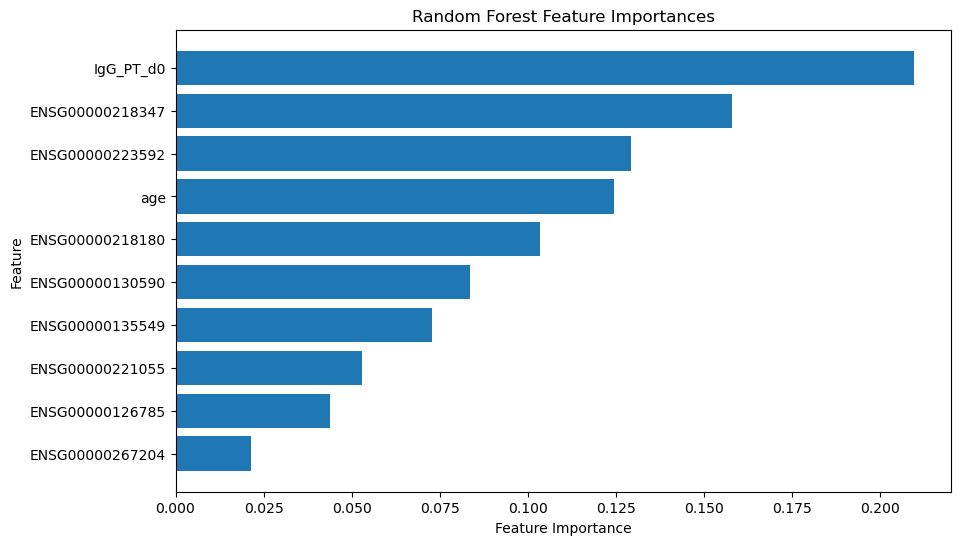

In [500]:
# Use Random Forest Regressor to select features
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)
feature_importances = rf_model.feature_importances_

threshold = 0.015
selected_features = X_train_scaled.columns[feature_importances > threshold]

X_train_scaled_selected = X_train_scaled
X_test_scaled_selected = X_test_scaled

print("Selected Features:", selected_features)
print("Feature Importances:", feature_importances)
[x for _, x in sorted(zip(feature_importances, X_train_scaled))]
[y for y,x in sorted(zip(feature_importances, X_train_scaled))]
plt.figure(figsize=(10, 6))
plt.barh([x for _, x in sorted(zip(feature_importances, X_train_scaled))], [y for y,x in sorted(zip(feature_importances, X_train_scaled))], align="center")
plt.yticks([x for _, x in sorted(zip(feature_importances, X_train_scaled))], [x for _, x in sorted(zip(feature_importances, X_train_scaled))])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()


In [481]:
# Random Forest Regression
rf_model = RandomForestRegressor()
param_dist_rf = {
    'n_estimators': [20,30,40,50,100,200, 300, 400,500,600,700],
    'max_depth': [10,13,15,17,20,22,25,27,30],
    'min_samples_split': [5, 10, 15,17,18,19,20],
    'min_samples_leaf': [1, 2, 3]
}

# Randomized Search CV for Random Forest
random_search_rf = RandomizedSearchCV(rf_model,
                                      param_distributions=param_dist_rf, 
                                      n_iter=10, 
                                      scoring='r2',  
                                      cv=5, 
                                      random_state=42)
random_search_rf.fit(X_train_scaled_selected, y_train)

# Print best parameters for Random Forest
print("Random Forest - Best Parameters:", random_search_rf.best_params_)

# Evaluate Random Forest on the test set using R-squared
y_pred_rf = random_search_rf.predict(X_test_scaled_selected)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest - R-squared on Test Set:", r2_rf)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled_selected, y_train)

# Evaluate Linear Regression on the test set using R-squared
y_pred_lr = lr_model.predict(X_test_scaled_selected)
r2_lr = r2_score(y_test, y_pred_lr)
print("Linear Regression - R-squared on Test Set:", r2_lr)

# Support Vector Regression
svr_model = SVR()
param_dist_svr = {
    'C': [5, 10, 15],
    'kernel': ['linear', 'rbf']
}

# Randomized Search CV for SVR
random_search_svr = RandomizedSearchCV(svr_model, param_distributions=param_dist_svr, n_iter=5, scoring='r2', 
                                       cv=5, random_state=42)
random_search_svr.fit(X_train_scaled_selected, y_train)

# Print best parameters for SVR
print("SVR - Best Parameters:", random_search_svr.best_params_)

# Evaluate SVR on the test set using R-squared
y_pred_svr = random_search_svr.predict(X_test_scaled_selected)
r2_svr = r2_score(y_test, y_pred_svr)
print("SVR - R-squared on Test Set:", r2_svr)

# Gradient Boosting Regression
gb_model = GradientBoostingRegressor()
param_dist_gb = {
    'n_estimators': [35,36,37,38,39,40,41,42,43],
    'learning_rate': [0.001,0.01,0.02,0.03, 0.05, 0.08,0.1,0.2,0.5,1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4,6,8,10,15,20],
    'min_samples_leaf': [1, 2, 3]
}

# Randomized Search CV for Gradient Boosting
random_search_gb = RandomizedSearchCV(gb_model, param_distributions=param_dist_gb, n_iter=10, scoring='r2',  
                                       cv=5, random_state=42)
random_search_gb.fit(X_train_scaled_selected, y_train)

# Print best parameters for Gradient Boosting
print("Gradient Boosting - Best Parameters:", random_search_gb.best_params_)

# Evaluate Gradient Boosting on the test set using R-squared
y_pred_gb = random_search_gb.predict(X_test_scaled_selected)
r2_gb = r2_score(y_test, y_pred_gb)
print("Gradient Boosting - R-squared on Test Set:", r2_gb)

# Lasso Regression
lasso_model = Lasso()
param_dist_lasso = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]
}

# Randomized Search CV for Lasso
random_search_lasso = RandomizedSearchCV(lasso_model, param_distributions=param_dist_lasso, n_iter=5, scoring='r2', 
                                         cv=5, random_state=42)
random_search_lasso.fit(X_train_scaled_selected, y_train)

# Print best parameters for Lasso
print("Lasso - Best Parameters:", random_search_lasso.best_params_)

# Evaluate Lasso on the test set using R-squared
y_pred_lasso = random_search_lasso.predict(X_test_scaled_selected)
r2_lasso = r2_score(y_test, y_pred_lasso)
print("Lasso - R-squared on Test Set:", r2_lasso)

# Ridge Regression
ridge_model = Ridge()
param_dist_ridge = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]
}

# Randomized Search CV for Ridge
random_search_ridge = RandomizedSearchCV(ridge_model, param_distributions=param_dist_ridge, n_iter=5, scoring='r2', 
                                         cv=5, random_state=42)
random_search_ridge.fit(X_train_scaled_selected, y_train)

# Print best parameters for Ridge
print("Ridge - Best Parameters:", random_search_ridge.best_params_)

# Evaluate Ridge on the test set using R-squared
y_pred_ridge = random_search_ridge.predict(X_test_scaled_selected)
r2_ridge = r2_score(y_test, y_pred_ridge)
print("Ridge - R-squared on Test Set:", r2_ridge)

# ElasticNet Regression
elasticnet_model = ElasticNet()
param_dist_elasticnet = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Randomized Search CV for ElasticNet
random_search_elasticnet = RandomizedSearchCV(elasticnet_model, param_distributions=param_dist_elasticnet, n_iter=10, scoring='r2', 
                                               cv=5, random_state=42)
random_search_elasticnet.fit(X_train_scaled_selected, y_train)

# Print best parameters for ElasticNet
print("ElasticNet - Best Parameters:", random_search_elasticnet.best_params_)

# Evaluate ElasticNet on the test set using R-squared
y_pred_elasticnet = random_search_elasticnet.predict(X_test_scaled_selected)
r2_elasticnet = r2_score(y_test, y_pred_elasticnet)
print("ElasticNet - R-squared on Test Set:", r2_elasticnet)

# Decision Tree Regression
dt_model = DecisionTreeRegressor()
param_dist_dt = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10,15,20],
    'min_samples_leaf': [1, 2, 4,6,8,10,15,20,25,30,35]
}

# Randomized Search CV for Decision Tree
random_search_dt = RandomizedSearchCV(dt_model, param_distributions=param_dist_dt, n_iter=5, scoring='r2', 
                                      cv=5, random_state=42)
random_search_dt.fit(X_train_scaled_selected, y_train)

# Print best parameters for Decision Tree
print("Decision Tree - Best Parameters:", random_search_dt.best_params_)

# Evaluate Decision Tree on the test set using R-squared
y_pred_dt = random_search_dt.predict(X_test_scaled_selected)
r2_dt = r2_score(y_test, y_pred_dt)
print("Decision Tree - R-squared on Test Set:", r2_dt)

# K-Nearest Neighbors Regression
knn_model = KNeighborsRegressor()
param_dist_knn = {
    'n_neighbors': np.arange(1, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Randomized Search CV for KNN
random_search_knn = RandomizedSearchCV(knn_model, param_distributions=param_dist_knn, n_iter=10, scoring='r2', 
                                        cv=5, random_state=42)
random_search_knn.fit(X_train_scaled_selected, y_train)

# Print best parameters for KNN
print("KNN - Best Parameters:", random_search_knn.best_params_)

# Evaluate KNN on the test set using R-squared
y_pred_knn = random_search_knn.predict(X_test_scaled_selected)
r2_knn = r2_score(y_test, y_pred_knn)
print("KNN - R-squared on Test Set:", r2_knn)

# Compare r2 of different models
r2_dict = {'Random Forest': r2_rf, 'Linear Regression': r2_lr, 'SVR': r2_svr, 'Gradient Boosting': r2_gb,
            'Lasso': r2_lasso, 'Ridge': r2_ridge, 'ElasticNet': r2_elasticnet, 
            'Decision Tree': r2_dt, 'KNN': r2_knn}

# Find the model with the highest r2
best_model_name = max(r2_dict, key=r2_dict.get)
best_model = None

# Select the best model
if best_model_name == 'Random Forest':
    best_model = random_search_rf
elif best_model_name == 'Linear Regression':
    best_model = lr_model
elif best_model_name == 'SVR':
    best_model = random_search_svr
elif best_model_name == 'Gradient Boosting':
    best_model = random_search_gb
elif best_model_name == 'Lasso':
    best_model = random_search_lasso
elif best_model_name == 'Ridge':
    best_model = random_search_ridge
elif best_model_name == 'ElasticNet':
    best_model = random_search_elasticnet
elif best_model_name == 'Decision Tree':
    best_model = random_search_dt
elif best_model_name == 'KNN':
    best_model = random_search_knn

print(f"\nBest Model: {best_model_name} with R-squared: {r2_dict[best_model_name]}")


Random Forest - Best Parameters: {'n_estimators': 500, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_depth': 20}
Random Forest - R-squared on Test Set: -0.2984043509083887
Linear Regression - R-squared on Test Set: -0.15390346171618652
SVR - Best Parameters: {'kernel': 'rbf', 'C': 5}
SVR - R-squared on Test Set: -0.05473542635660311
Gradient Boosting - Best Parameters: {'n_estimators': 40, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_depth': 2, 'learning_rate': 0.01}
Gradient Boosting - R-squared on Test Set: -0.40508976582043066
Lasso - Best Parameters: {'alpha': 1}
Lasso - R-squared on Test Set: -0.3815576435272039
Ridge - Best Parameters: {'alpha': 10}
Ridge - R-squared on Test Set: -0.36438566869146394
ElasticNet - Best Parameters: {'l1_ratio': 0.5, 'alpha': 10}
ElasticNet - R-squared on Test Set: -0.29774416272883597
Decision Tree - Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 15, 'max_depth': None}
Decision Tree - R-squared on Test Set: -0.49221638

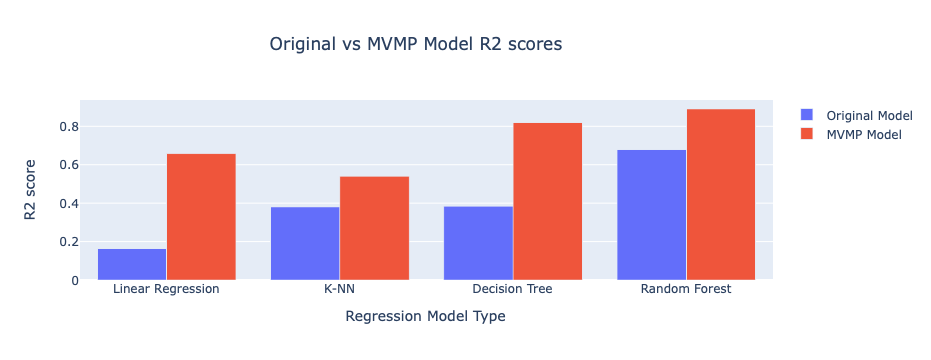

In [480]:
import plotly.graph_objects as px
plot = px.Figure(data=[
                       px.Bar(
    name = 'Original Model',
    x = mods,
    y = og
   ),
    px.Bar(
    name = 'MVMP Model',
    x = mods,
    y = new
   ),
], )

plot.update_layout(title= 'Original vs MVMP Model R2 scores', title_x=0.29, xaxis_title = 'Regression Model Type', yaxis_title='R2 score')
#plot.update_yaxes('R2 score')
#plot.update_xaxes('Regression Model Type')
plot.show()



## Data Feature Selection & Cleaning

In [ ]:
## getting separate rows for day 0 MFI_normalized results and day 14 MFI_normalized results for IgG_PT 
IgG_d14 = IgG_1[IgG_1['planned_day_relative_to_boost'] == 14.0]
IgG_d0 = IgG_1[IgG_1['planned_day_relative_to_boost'] == 0.0][['subject_id', 'IgG_PT']]
IgG_d0 = IgG_d0.rename(columns={'subject_id': 'subject_id', 'IgG_PT': 'IgG_PT_d0'})
IgG_d14 = IgG_d14.merge(IgG_d0, on='subject_id')

In [ ]:
IgG_d14 = IgG_d14[['infancy_vac', 'biological_sex', 'age', 'year_of_birth', 'ethnicity', 'race', 'visit', 'IgG_PT_d0', 'IgG_PT']]

In [ ]:
IgG_d14.head()

One Hot Encoding and mapping string data into numerical type for Regression training

In [327]:
IgG_d14['infancy_vac'] = IgG_d14['infancy_vac'].map({'wP':0, 'aP':1})

In [328]:
IgG_d14['biological_sex'] = IgG_d14['biological_sex'].map({'Female':0, 'Male':1})

In [329]:
IgG_d14['ethnicity'] = IgG_d14['ethnicity'].map({'Not Hispanic or Latino':0, 
                                                   'Hispanic or Latino':1,
                                                   'Unknown':2})

In [330]:
IgG_d14['race'] = IgG_d14['race'].map({'White':0, 
                                       'Asian':1,
                                       'Unknown or Not Reported': 2,
                                       'More Than One Race': 2,
                                       'Black or African American': 3,
                                       'Native Hawaiian or Other Pacific Islander': 4,
                                       'American Indian/Alaska Native':5
                                      })
IgG_d14.head()

,infancy_vac,biological_sex,age,year_of_birth,ethnicity,race,visit,IgG_PT_d0,IgG_PT
0,0,0,30,1986,0,0,5,3.736992,10.874112
1,0,0,33,1983,2,0,5,1.096366,7.041547
2,0,1,28,1988,0,1,5,2.046671,7.896541
3,0,1,25,1991,0,1,5,3.798007,5.327203
4,0,0,28,1988,0,0,5,0.213328,9.128886


## Training and Evaluating Models

In [374]:
X = IgG_d14.drop('IgG_PT', axis = 1)
y = IgG_d14['IgG_PT']

In [375]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=r_regression, k=8)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores.nlargest(100,'Score'))  #print 10 best features

         Features     Score
7       IgG_PT_d0  0.309570
2             age  0.214940
4       ethnicity  0.076466
5            race -0.003747
6           visit -0.004199
1  biological_sex -0.096522
0     infancy_vac -0.145532
3   year_of_birth -0.201428


In [376]:
featureScores.sort_values(by=['Score'], ascending = False).reset_index(drop=True).head(10)

,Features,Score
0,IgG_PT_d0,0.309570
1,age,0.214940
2,ethnicity,0.076466
3,race,-0.003747
4,visit,-0.004199
5,biological_sex,-0.096522
6,infancy_vac,-0.145532
7,year_of_birth,-0.201428


In [377]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

First we will test a simple naive model, Linear Regression, to get a baseline of how a model should at least perform

In [378]:
reg = LinearRegression().fit(X, y)

In [379]:
reg.score(X, y)

0.1650436797649475

The MSE, MAE, and R2 scores were mediocre at best, and could defintely be improved upon

In [380]:
Y_pred = reg.predict(X)

In [381]:
mse = mean_squared_error(y, Y_pred)
mae = mean_absolute_error(y, Y_pred)
r2 = r2_score(y, Y_pred)
mse, mae, r2

(21.592059006324835, 3.6543297180405743, 0.1650436797649475)

Next, we will test ElasticNet, a combination of Ridge and Lasso Regression

In [382]:
model = ElasticNet()
model.fit(X, y)

ElasticNet()

In [383]:
Y_pred = model.predict(X)

In [384]:
mse = mean_squared_error(y, Y_pred)
mae = mean_absolute_error(y, Y_pred)
r2 = r2_score(y, Y_pred)
mse, mae, r2

(22.09278417730857, 3.7085192730424317, 0.14568083687482836)

Since our training data we are working with is fairly constricted in size, we will take a look at how KNeighborsRegressor will perform

In [385]:
kn = KNeighborsRegressor()
kn.fit(X, y)

KNeighborsRegressor()

In [386]:
Y_pred = kn.predict(X)

In [387]:
mse = mean_squared_error(y, Y_pred)
mae = mean_absolute_error(y, Y_pred)
r2 = r2_score(y, Y_pred)
mse, mae, r2

(16.129934626932343, 3.0703156584806424, 0.37626185359208475)

The results are promising with a R2 score of 0.43 on a scale from 0 to 1, alot better than our baseline with Linear Regression of 0.15. The MSE score was also improved upon.

Lastly, we will test DecisionTreeRegressor to see how it performs in comparison to KNeighborsRegressor

In [388]:
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_3 = DecisionTreeRegressor(max_depth=10)
regr_1.fit(X, y)
regr_2.fit(X, y)
regr_3.fit(X, y)

DecisionTreeRegressor(max_depth=10)

In [389]:
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)
y_3 = regr_3.predict(X)

In [390]:
mse = mean_squared_error(y, y_1)
mae = mean_absolute_error(y, y_1)
r2 = r2_score(y, y_1)
mse, mae, r2

(15.927582684728465, 3.0081246225292047, 0.3840867225869997)

In [391]:
mse = mean_squared_error(y, y_2)
mae = mean_absolute_error(y, y_2)
r2 = r2_score(y, y_2)
mse, mae, r2

(11.875539130493431, 2.2725830350587057, 0.5407776326333831)

In [392]:
mse = mean_squared_error(y, y_3)
mae = mean_absolute_error(y, y_3)
r2 = r2_score(y, y_3)
mse, mae, r2

(0.5575911007495251, 0.33231507317888076, 0.9784381742592839)

In [393]:
rf = RandomForestRegressor()
rf.fit(X, y)
Y_pred = rf.predict(X)

In [395]:
mse = mean_squared_error(y, Y_pred)
mae = mean_absolute_error(y, Y_pred)
r2 = r2_score(y, Y_pred)
mse, mae, r2

(3.567596736855357, 1.3810360715017191, 0.8620424553946072)

In [398]:
og= [0.165,0.38,0.384, 0.68]
new = [0.657,0.54,0.82,0.89]
mods=['Linear Regression', 'K-NN', 'Decision Tree', 'Random Forest']


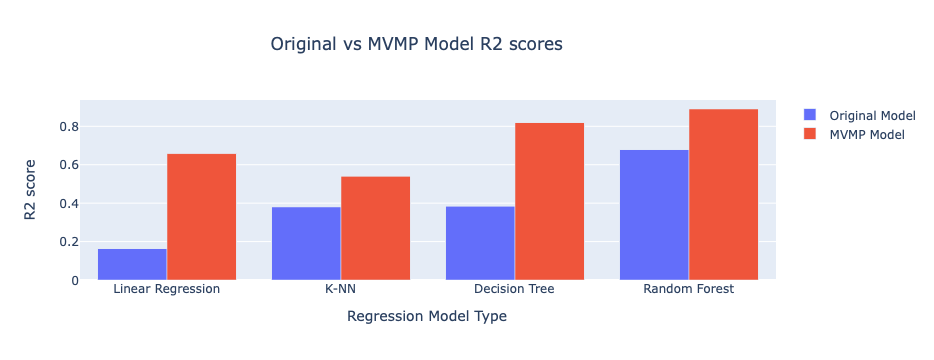

In [410]:
import plotly.graph_objects as px
plot = px.Figure(data=[
                       px.Bar(
    name = 'Original Model',
    x = mods,
    y = og
   ),
    px.Bar(
    name = 'MVMP Model',
    x = mods,
    y = new
   ),
], )

plot.update_layout(title= 'Original vs MVMP Model R2 scores', title_x=0.29, xaxis_title = 'Regression Model Type', yaxis_title='R2 score')
#plot.update_yaxes('R2 score')
#plot.update_xaxes('Regression Model Type')
plot.show()



## 2022 Validation Predictions

#### Loading in 2022 prediction datasets: titer, specimen, and subject

In [1]:
titers_pred = clean_df_titer(df_2022_titer)

NameError: name 'clean_df_titer' is not defined

In [129]:
subject_pred = clean_df_subject(pd.merge(df_2022_specimen,df_2022_subject, on= 'subject_id'))

In [130]:
IgG = subject_pred.merge(titers_pred, on='specimen_id', how = 'outer')

In [131]:
IgG.columns

Index(['specimen_id', 'subject_id', 'actual_day_relative_to_boost',
       'planned_day_relative_to_boost', 'specimen_type', 'visit',
       'infancy_vac', 'biological_sex', 'ethnicity', 'race', 'year_of_birth',
       'date_of_boost', 'dataset', 'age', 'IgG_PT'],
      dtype='object')

In [132]:
IgG = IgG[['subject_id',
           'specimen_id',
           'infancy_vac',
           'biological_sex',
           'age',
           'year_of_birth',
           'date_of_boost',
           'actual_day_relative_to_boost',
           'planned_day_relative_to_boost',
           'ethnicity',
           'race',
           'dataset',
           'specimen_type',
           'visit',
           'IgG_PT']]

In [133]:
IgG = IgG[IgG['planned_day_relative_to_boost'].isin([0])]

In [134]:
IgG_d= IgG[['infancy_vac', 'biological_sex', 'year_of_birth', 'ethnicity', 'race', 'visit', 'IgG_PT']].rename(columns={'IgG_PT': 'IgG_PT_d0'})

#### Data Feature Selection & Cleaning

In [135]:
IgG_d['infancy_vac'] = IgG_d['infancy_vac'].map({'wP':0, 'aP':1})

In [136]:
IgG_d['biological_sex'] = IgG_d['biological_sex'].map({'Female':0, 'Male':1})

In [137]:
IgG_d['ethnicity'] = IgG_d['ethnicity'].map({'Not Hispanic or Latino':0, 
                                                   'Hispanic or Latino':1,
                                                   'Unknown':2})

In [138]:
IgG_d['race'] = IgG_d['race'].map({'White':0, 
                                       'Asian':1,
                                       'Unknown or Not Reported': 2,
                                       'More Than One Race': 2,
                                       'Black or African American': 3,
                                       'Native Hawaiian or Other Pacific Islander': 4,
                                       'American Indian/Alaska Native':5
                                      })
IgG_d.head()

,infancy_vac,biological_sex,year_of_birth,ethnicity,race,visit,IgG_PT_d0
2,0,1,1986,0,0,3,1.060618
12,0,0,1993,0,0,5,1.309938
22,1,0,1999,1,2,5,1.196227
32,1,0,2001,0,0,5,0.967752
42,1,1,2003,0,0,3,1.651583


#### Getting predictions from our Model

In [143]:
y_pred = regr_3.predict(IgG_d)

In [146]:
rank = [abs(sorted(y_3).index(x)-19) for x in y_3]

In [147]:
IgG['1.1) IgG-PT-D14-titer-Rank'] = rank

In [148]:
IgG[['subject_id', 'age', 'biological_sex', 'infancy_vac', '1.1) IgG-PT-D14-titer-Rank']]

,subject_id,age,biological_sex,infancy_vac,1.1) IgG-PT-D14-titer-Rank
2,97,35,Male,wP,6
12,98,28,Female,wP,4
22,99,22,Female,aP,8
32,100,20,Female,aP,17
42,101,18,Male,aP,3
52,102,18,Male,aP,3
62,103,27,Female,wP,1
72,104,32,Female,wP,12
81,105,27,Female,wP,11
91,106,25,Female,aP,14
